# Tłumaczenie Transformerem

![Alt text](image-1.png)

In [1]:
import os
import datetime
import pickle
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import re
import numpy as np

/tmp/ipykernel_1961869/3492076321.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


ModuleNotFoundError: No module named 'matplotlib'

In [4]:
max_tokens = 25_000
sequence_length = 30

# Przygotowanie danych
![Alt text](image.png)

## Wczytanie

In [5]:
file_path = '../data/en-pl.csv'
df = pd.read_csv(file_path)
df['source'] = df['pl']
df['target'] = df['en'].apply(lambda x: '[start] ' + x + ' [end]')
df = df.drop(['pl', 'en'], axis=1)
df.sample(5)

,source,target
1180750,Box 56A Town / Prov:,[start] Box 56A Town/Prov: [end]
4158654,Istnieje jednak potrzeba rozróżnienia między u...,"[start] However, there is the need to differen..."
2076236,Serge Corbeil - 604- 732- 1420) Asian Society ...,[start] Serge Corbeil - 604-732-1420) Asian So...
3169967,W latach 1992-2001 udział wywozu kanadyjskiego...,"[start] Between 1992 and 2001, the proportion ..."
68714,Steven Perelstein Rodzaj działalności:,[start] Steven Perelstein Type of Business: [end]


## Podział na podzbiory

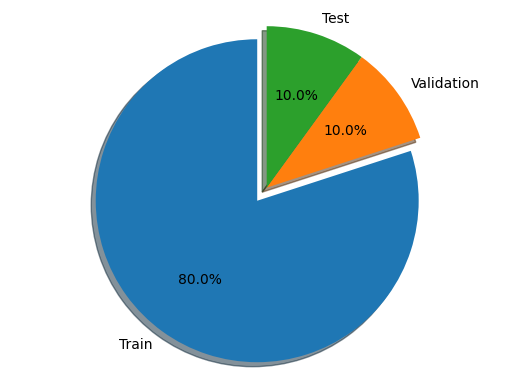

In [ ]:
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)
test_size = int(len(df) * 0.1)

train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

In [7]:
# define a custom standardization function that convert to lowercase and strips all punctuations except "[" and "]" (so we can tell apart "start" from "[start]").
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
 
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

In [7]:
# tokenize the data using our custom standardization function
source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length + 1, # add +1 token to our target sentences since they'll be shifted right by 1 during training
    standardize=custom_standardization,
)

# index all tokens in the source and target sentences
train_source_texts = train_df['source'].values
train_target_texts = train_df['target'].values

2024-01-24 02:05:04.524484: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 02:05:04.524710: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 02:05:04.524782: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
source_vectorization.adapt(train_source_texts)

In [11]:
target_vectorization.adapt(train_target_texts)

In [16]:
def save_text_vectorization(text_vec, path):
    standardize = target_vectorization._standardize
    target_vectorization._standardize = None
    pickle.dump({
        'config': text_vec.get_config(),
        'weights': text_vec.get_weights()
        }, open(path, "wb")
    )
    target_vectorization._standardize = standardize

In [8]:
def load_text_vectorization(path, standardize=None):
    from_disk = pickle.load(open(path, "rb"))
    new_v = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
    if standardize:
        new_v._standardize = standardize
    new_v.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
    new_v.set_weights(from_disk['weights'])
    return new_v

In [10]:
save_text_vectorization(source_vectorization, '../checkpoints/source_vec.pkl')

In [12]:
save_text_vectorization(target_vectorization, '../checkpoints/target_vec.pkl')

In [9]:
source_vectorization = load_text_vectorization('../checkpoints/source_vec.pkl')

2024-01-24 03:06:06.409474: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 03:06:06.409637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 03:06:06.409710: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [10]:
target_vectorization = load_text_vectorization('../checkpoints/target_vec.pkl', custom_standardization)

In [11]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim) # token embedding layer
        self.position_embeddings = tf.keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim) # position embedding layer
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs) # embed the tokens
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # create the positional information
        embedded_positions = self.position_embeddings(positions) # embed the positions 
        return embedded_tokens + embedded_positions # add the token and position embeddings to create the positional embeddings

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
        })
        return config

In [12]:
# credits to OpenAI for that one (https://github.com/openai/gpt-2/blob/master/src/model.py)

def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def attention_mask(nd, ns, *, dtype):
    """1's in the lower triangle, counting from the lower right corner.
    Same as tf.matrix_band_part(tf.ones([nd, ns]), -1, ns-nd), but doesn't produce garbage on TPUs.
    """
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)

def mask_attn_weights(w):
    # w has shape [batch, heads, dst_sequence, src_sequence], where information flows from src to dst.
    _, _, nd, ns = shape_list(w)
    b = attention_mask(nd, ns, dtype=w.dtype)
    b = tf.reshape(b, [1, 1, nd, ns])
    w = w*b - tf.cast(1e10, w.dtype)*(1-b)
    return w

In [13]:
def scaled_dot_product_attention(q, k, v, use_causal_mask=False):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scores = tf.matmul(q, k, transpose_b=True) # Matmul of Q and K
    scaled_scores = scores / tf.math.sqrt(d_k) # Scale
    if use_causal_mask:
        scaled_scores = mask_attn_weights(scaled_scores) # Mask (opt.)
    weights = tf.nn.softmax(scaled_scores, axis=-1) # SoftMax
    output = tf.matmul(weights, v) # Matmul of SoftMax and V
    return output

In [14]:
class MultiAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, h, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.h = h
        if embed_dim % h != 0:
            raise ValueError(
                f"dimension of the embedding space = {embed_dim} should be divisible by number of heads = {h}"
            )
        self.q_linear = tf.keras.layers.Dense(embed_dim)
        self.k_linear = tf.keras.layers.Dense(embed_dim)
        self.v_linear = tf.keras.layers.Dense(embed_dim)
        self.concat_linear = tf.keras.layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, shape=(batch_size, -1, self.h, self.embed_dim // self.h))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def concat_heads(self, x, batch_size):
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(x, (batch_size, -1, self.embed_dim))

    def call(self, q, k, v, use_causal_mask=False):
        batch_size = tf.shape(k)[0]
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        attention = scaled_dot_product_attention(q, k, v, use_causal_mask)
        concat = self.concat_heads(attention, batch_size)
        concat = self.concat_linear(concat)
        return concat

    def get_config(self):
        config = super(MultiAttention, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "h": self.h,
        })
        return config

In [17]:
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.layer_norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-7)
        self.layer_norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-7)
        self.global_self_attention = MultiAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        
    def call(self, x):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.global_self_attention(q=x, k=x, v=x))
        x = self.layer_norm_2(x + self.feed_forward(x))
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

In [18]:
class TransformerDecoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.causal_self_attention = MultiAttention(embed_dim=embed_dim, h=num_heads)
        self.cross_attention = MultiAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        self.layer_norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-7)
        self.layer_norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-7)
        self.layer_norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-7)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

    def call(self, x, context):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.causal_self_attention(q=x, k=x, v=x, use_causal_mask=True))
        x = self.layer_norm_2(x + self.cross_attention(q=x, k=context, v=context))
        x = self.layer_norm_3(x + self.feed_forward(x))
        return x

In [19]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, num_layers):
        super(TransformerEncoder, self).__init__()
        self.transformer_encoders = [TransformerEncoderBlock(embed_dim, dense_dim, num_heads) for _ in range(num_layers)]

    def call(self, x):
        for encoder in self.transformer_encoders:
            x = encoder(x)
        return x

In [20]:
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, num_layers):
        super(TransformerDecoder, self).__init__()
        self.transformer_decoders = [TransformerDecoderBlock(embed_dim, dense_dim, num_heads) for _ in range(num_layers)]

    def call(self, x, context):
        for encoder in self.transformer_decoders:
            x = encoder(x, context)
        return x

In [22]:
class TransformerModel(tf.keras.Model):
    def __init__(self, sequence_length, max_tokens, embed_dim, dense_dim, num_heads, encoder_layers, decoder_layers):
        super(TransformerModel, self).__init__()

        self.encoder_embedding = PositionalEmbedding(sequence_length, max_tokens, embed_dim)
        self.decoder_embedding = PositionalEmbedding(sequence_length, max_tokens, embed_dim)
        
        self.encoder = TransformerEncoder(embed_dim, dense_dim, num_heads, encoder_layers)
        self.decoder = TransformerDecoder(embed_dim, dense_dim, num_heads, decoder_layers)
        
        # Transformer head
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.dense = tf.keras.layers.Dense(max_tokens, activation="softmax")

    def call(self, inputs, training=False):
        encoder_inputs = inputs['source']
        decoder_inputs = inputs['target']
        
        encoder_embedding = self.encoder_embedding(encoder_inputs)
        decoder_embedding = self.decoder_embedding(decoder_inputs)
        
        encoder_outputs = self.encoder(encoder_embedding)
        decoder_outputs = self.decoder(decoder_embedding, encoder_outputs)

        x = self.dropout(decoder_outputs, training=training)
        x = self.dense(x)
        return x

In [27]:
embed_dim = 128
dense_dim = 4 * embed_dim
num_heads = 8
encoder_layers = 4
decoder_layers = 4

In [28]:
transformer = TransformerModel(sequence_length, max_tokens, embed_dim, dense_dim, num_heads, encoder_layers, decoder_layers)

In [29]:
def format_dataset(source, target):
    source_vectors = source_vectorization(source)
    target_vectors = target_vectorization(target)
    return ({
        "source": source_vectors, # encoder_inputs
        "target": target_vectors[:, :-1], # decoder_inputs (truncate by 1 to keep it at the same length as decoder_outputs, which is shifted right by 1).
    }, target_vectors[:, 1:]) # decoder_outputs

def make_dataset(df, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((df["source"].values, df["target"].values))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(100_000).prefetch(16).cache()

batch_size = 512
train_ds = make_dataset(train_df, batch_size)
val_ds = make_dataset(val_df, batch_size)

In [30]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

EPOCHS = 1000
checkpoint_filepath = '../checkpoints/model/'
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )
]
    
transformer.fit(train_ds, 
                epochs=EPOCHS, 
                callbacks=callbacks_list,
                validation_data=val_ds)

Epoch 1/1000
6664/6664 [==============================] - 1900s 281ms/step - loss: 3.4274 - accuracy: 0.5095 - val_loss: 1.6536 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 2/1000
6664/6664 [==============================] - 1871s 281ms/step - loss: 1.5683 - accuracy: 0.7312 - val_loss: 1.2418 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 3/1000
6664/6664 [==============================] - 1869s 280ms/step - loss: 1.3635 - accuracy: 0.7571 - val_loss: 1.1704 - val_accuracy: 0.7767 - lr: 0.0010
Epoch 4/1000
6664/6664 [==============================] - 1870s 281ms/step - loss: 1.2880 - accuracy: 0.7669 - val_loss: 1.1343 - val_accuracy: 0.7811 - lr: 0.0010
Epoch 5/1000
6664/6664 [==============================] - 1869s 280ms/step - loss: 1.2460 - accuracy: 0.7725 - val_loss: 1.0961 - val_accuracy: 0.7876 - lr: 0.0010
Epoch 6/1000
6664/6664 [==============================] - 1869s 280ms/step - loss: 1.2191 - accuracy: 0.7764 - val_loss: 1.0837 - val_accuracy: 0.7898 - lr: 0.0010
Epoch 7/1000
666

KeyboardInterrupt: 

In [ ]:
transformer.save('../checkpoints/full_model/')

In [70]:
transformer = tf.keras.models.load_model('../checkpoints/model/')

# Testing

In [37]:
decode_sequence('Idę jutro do kina na film o ptakach')

'[start] i go tomorrow to a movie [UNK] [end]'

In [39]:
decode_sequence('Tłumaczenie działa bardzo fajnie')

'[start] translation is working very [UNK] [end]'

In [38]:
target_vocab = target_vectorization.get_vocabulary()
target_index_lookup = dict(zip(range(len(target_vocab)), target_vocab))
max_decoded_sentence_length = 30

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            {'source': tokenized_input_sentence, 'target': tokenized_target_sentence})
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

# let's translate 50 random sentences
for i in range(50):
    random_index = np.random.randint(0, len(test_df))
    input_sentence = test_df["source"].iloc[random_index]
    print(input_sentence)
    print(decode_sequence(input_sentence))
    print()

Przestrzeń wolności szersza koncepcja wolności Szersza koncepcja wolności zawarta w traktacie z Amsterdamu ma na celu nadanie upustu * wolności: znaczenia wykraczającego poza swobodny przepływ osób przez granice wewnętrzne.
[start] area of freedom broader concept of freedom a broader concept of freedom in the treaty of [UNK] is designed to give [UNK] freedom of meaning to [UNK] beyond the free

• Brak informacji (kod NI w OWNERS)
[start] • lack of information code ni in [UNK] [end]

Wygląd fizyczny Płeć Mężczyzna Rank Ocdt Baza Esquimalt Element Armii
[start] physical appearance gender male [UNK] [UNK] [UNK] element element of the army [end]

(Wykres organizacyjny projektu) Załącznik II:
[start] project organizational chart appendix ii [end]

Biuro Międzynarodowe stwierdziło, że zamiast "kraju" lub "terytorium" użyto słów "państwa członkowskie", tak jak we wspólnym zaleceniu w sprawie znakowanych znaków towarowych, a w przyszłości można je zmienić na "Umawiającą się Stronę", jeżeli SCT